# Debugging the design

In [1]:
%load_ext autoreload
%autoreload 2

import uuid
import argparse
import dgym as dg
import pandas as pd

def get_data(path):

    deck = dg.MoleculeCollection.load(
        f'{path}/DSi-Poised_Library_annotated.sdf',
        reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
    )

    reactions = dg.ReactionCollection.from_json(
        path = f'{path}/All_Rxns_rxn_library_sorted.json',
        smarts_col = 'reaction_string',
        classes_col = 'functional_groups'
    )

    building_blocks = dg.datasets.disk_loader(
        f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
    fingerprints = dg.datasets.fingerprints(
        f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

    import torch
    import pyarrow.parquet as pq
    table = pq.read_table(f'{path}/sizes.parquet')[0]
    sizes = torch.tensor(table.to_numpy())

    return deck, reactions, building_blocks, fingerprints, sizes

In [2]:
_, reactions, building_blocks, fingerprints, sizes = get_data('../../dgym-data/')

In [3]:
from dgym.envs.designer import Designer, Generator

generator = Generator(building_blocks, fingerprints, sizes)
designer = Designer(generator, reactions)

### Visualizing molecules

In [270]:
# start = designer.design(1)[0]

routines = [
    {'temperature': 0.0, 'limit': 1},
    {'temperature': 0.02, 'limit': 1},
    {'temperature': 0.04, 'limit': 1},
    {'temperature': 0.08, 'limit': 1},
    {'temperature': 0.16, 'limit': 1},
    {'temperature': 0.32, 'limit': 1},
    {'temperature': 0.64, 'limit': 1},
    {'temperature': 0.0, 'limit': 2},
    {'temperature': 0.02, 'limit': 2},
    {'temperature': 0.04, 'limit': 2},
    {'temperature': 0.08, 'limit': 2},
    {'temperature': 0.16, 'limit': 2},
    {'temperature': 0.32, 'limit': 2},
    {'temperature': 0.64, 'limit': 2},
    {'temperature': 0.0, 'limit': 10},
    {'temperature': 0.02, 'limit': 10},
    {'temperature': 0.04, 'limit': 10},
    {'temperature': 0.08, 'limit': 10},
    {'temperature': 0.16, 'limit': 10},
    {'temperature': 0.32, 'limit': 10},
    {'temperature': 0.64, 'limit': 10}
]

results = []
for r in routines:
    temperature, limit = r.values()
    # designer.reset()
    res = designer.design(
        start, 1, temperature=temperature,
        limit=limit
    )[0]
    results.append(res)

# gen = designer.generator([start.reactants[1]], search='similar', temperature=0.04)
# mols = [next(gen[0]).mol for _ in range(10)]

from rdkit.Chem.Draw import MolsToGridImage
print('temperature', temperature, 'limit', limit)
MolsToGridImage([r.mol for r in results], molsPerRow=3, subImgSize=[400, 400], useSVG=True)

## Testing average expected Tanimoto similarity for different routines

In [249]:
import numpy as np

def compute_tanimoto_similarity(fp1, fp2):
    """
    Computes the Tanimoto similarity between two binary fingerprint arrays.

    Parameters:
    fp1 (np.array): Numpy array representing the first binary fingerprint.
    fp2 (np.array): Numpy array representing the second binary fingerprint.

    Returns:
    float: Tanimoto similarity score between the two fingerprints.
    """
    # Convert RDKit ExplicitBitVect to numpy arrays
    arr1 = np.array(fp1)
    arr2 = np.array(fp2)

    # Compute the intersection and union of the fingerprints
    intersection = np.sum(arr1 & arr2)
    union = np.sum(arr1 | arr2)

    # Compute Tanimoto similarity
    tanimoto_similarity = intersection / union
    return tanimoto_similarity

In [368]:
routines = [
    {'temperature': 0.0, 'limit': 1},
    {'temperature': 0.02, 'limit': 1},
    {'temperature': 0.04, 'limit': 1},
    {'temperature': 0.08, 'limit': 1},
    {'temperature': 0.16, 'limit': 1},
    {'temperature': 0.32, 'limit': 1},
    {'temperature': 0.64, 'limit': 1},
    {'temperature': 0.0, 'limit': 2},
    {'temperature': 0.02, 'limit': 2},
    {'temperature': 0.04, 'limit': 2},
    {'temperature': 0.08, 'limit': 2},
    {'temperature': 0.16, 'limit': 2},
    {'temperature': 0.32, 'limit': 2},
    {'temperature': 0.64, 'limit': 2},
    {'temperature': 0.0, 'limit': 10},
    {'temperature': 0.02, 'limit': 10},
    {'temperature': 0.04, 'limit': 10},
    {'temperature': 0.08, 'limit': 10},
    {'temperature': 0.16, 'limit': 10},
    {'temperature': 0.32, 'limit': 10},
    {'temperature': 0.64, 'limit': 10}
]

def make_design(designer, start, size: int = 1, creativity: int = 0):
        
    routine = routines[creativity]
    temperature, limit = routine.values()
    res = designer.design(start, size, temperature=temperature, limit=limit)
    return res

def retry_until_success(function, *args,  max_attempts=5, **kwargs):
    """
    Continuously tries to execute a function until it succeeds, catching exceptions.

    Parameters:
        function: The function to execute.
        max_attempts (int): The maximum number of attempts before giving up.

    Returns:
        The return value of the function if successful, or raises the last caught exception.
    """
    attempt = 0
    while attempt < max_attempts:
        try:
            return function(*args, **kwargs)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed with error: {e}")
            attempt += 1
            if attempt == max_attempts:
                raise e

In [ ]:
from tqdm.auto import tqdm
from scikit_mol.fingerprints import RDKitFingerprintTransformer
fingerprinter = RDKitFingerprintTransformer(parallel=True)

records = []
for _ in tqdm(range(500)):
    
    designer.reset()
    start_1_step = designer.design(1)[0]
    start_2_step = designer.design(start_1_step, 1, strategy='grow')[0]
    
    analogs = []
    for creativity in range(21):
        analog = retry_until_success(make_design, designer, start_2_step, 10, creativity)            
        analogs.extend(analog)

    progression = [start_2_step.mol, *[a.mol for a in analogs]]
    fps = fingerprinter.transform(progression)
    similarities = [compute_tanimoto_similarity(fps[0], f) for f in fps]
    
    records.append(similarities[1:])

  0%|          | 0/500 [00:00<?, ?it/s]

In [405]:
import pandas as pd
import seaborn as sns

df_raw = pd.DataFrame(records)

k = 5
averages = []
for i in range(21):
    subset = df_raw.loc[:,i*20:i*20+k]
    average = subset.mean(axis=1)
    averages.append(average)
df_top_k_average = pd.concat(averages, axis=1)

df = df_top_k_average.melt(var_name=['creativity'], value_name='similarity')
df['temperature'] = \
    df['creativity'].apply([r['temperature'] for r in routines].__getitem__)
df['# reactants changed'] = \
    df['creativity'].apply([r['limit'] for r in routines].__getitem__)
df_summary = (
    df
    .groupby('creativity')
    .agg({
        'similarity': ['mean', 'std'],
        'temperature': 'mean',
        '# reactants changed': 'mean'
    })
)

top_similarity = (
    df_summary
    .sort_values([('similarity', 'mean')], ascending=False)
)

top_similarity

similarity           temperature # reactants changed
                 mean       std        mean                mean
creativity                                                     
0            0.801972  0.085752        0.00                 1.0
1            0.788246  0.092696        0.02                 1.0
2            0.710051  0.143076        0.04                 1.0
14           0.629014  0.102839        0.00                10.0
7            0.627491  0.101037        0.00                 2.0
15           0.618991  0.102755        0.02                10.0
3            0.613747  0.119766        0.08                 1.0
8            0.601214  0.109109        0.02                 2.0
16           0.562157  0.106104        0.04                10.0
4            0.553089  0.099668        0.16                 1.0
9            0.498809  0.148548        0.04                 2.0
5            0.477525  0.098579        0.32                 1.0
6            0.446154  0.124714        0.64                 1.0
17           0.418428  0.092832        0.08                10.0
10           0.391127  0.104741        0.08                 2.0
11           0.310087  0.069340        0.16                 2.0
18           0.308955  0.067055        0.16                10.0
12           0.295090  0.060666        0.32                 2.0
19           0.294571  0.058305        0.32                10.0
20           0.291914  0.056363        0.64                10.0
13           0.289775  0.056495        0.64                 2.0

### Add utility

In [422]:
from io import StringIO

data = """timeline	KM_estimate	KM_estimate_lower_0.68	KM_estimate_upper_0.68	temperature_index	temperature	# reactants changed
201	2008.388778	0.472659	0.424214	0.523739	0	0.00	1
201	2008.388778	0.540000	0.491313	0.590209	1	0.02	1
201	2008.388778	0.530000	0.481322	0.580364	2	0.04	1
201	2008.388778	0.571338	0.522265	0.621440	3	0.08	1
201	2008.388778	0.878710	0.843849	0.908971	4	0.16	1
201	2008.388778	0.879381	0.844062	0.909954	5	0.32	1
201	2008.388778	0.857754	0.819252	0.891747	6	0.64	1
201	2008.388778	0.454363	0.406086	0.505584	7	0.00	2
201	2008.388778	0.394613	0.347699	0.445430	8	0.02	2
201	2008.388778	0.461017	0.412845	0.511999	9	0.04	2
201	2008.388778	0.664211	0.616845	0.711013	10	0.08	2
201	2008.388778	0.705529	0.659115	0.750636	11	0.16	2
201	2008.388778	0.634782	0.585091	0.684413	12	0.32	2
201	2008.388778	0.538257	0.488312	0.589837	13	0.64	2
201	2008.388778	0.210621	0.172290	0.256076	14	0.00	all
201	2008.388778	0.284872	0.242277	0.333168	15	0.02	all
201	2008.388778	0.317788	0.273383	0.367407	16	0.04	all
201	2008.388778	0.306104	0.261556	0.356238	17	0.08	all
201	2008.388778	0.242761	0.200097	0.292729	18	0.16	all
201	2008.388778	0.322510	0.275906	0.374745	19	0.32	all
201	2008.388778	0.338184	0.287659	0.394859	20	0.64	all"""

df_utility = pd.read_csv(StringIO(data), sep='\t')

df_utility_sorted = (
    df_utility
    .set_index('temperature_index')
    .loc[top_similarity.index]
    .drop('timeline', axis=1)
)

In [449]:
similarity_and_utility = pd.concat([top_similarity, df_utility_sorted], axis=1)
similarity_utility = similarity_and_utility.drop([('temperature', 'mean'), ('# reactants changed', 'mean')], axis=1)
similarity_utility = similarity_utility.rename(columns={
    ('similarity', 'mean'): 'tanimoto similarity (mean)',
    ('similarity', 'std'): 'tanimoto similarity (std)',
    'KM_estimate': 'utility',
})

Text(0.5, 1.0, 'Mean expected Tanimoto similarity vs. utility')

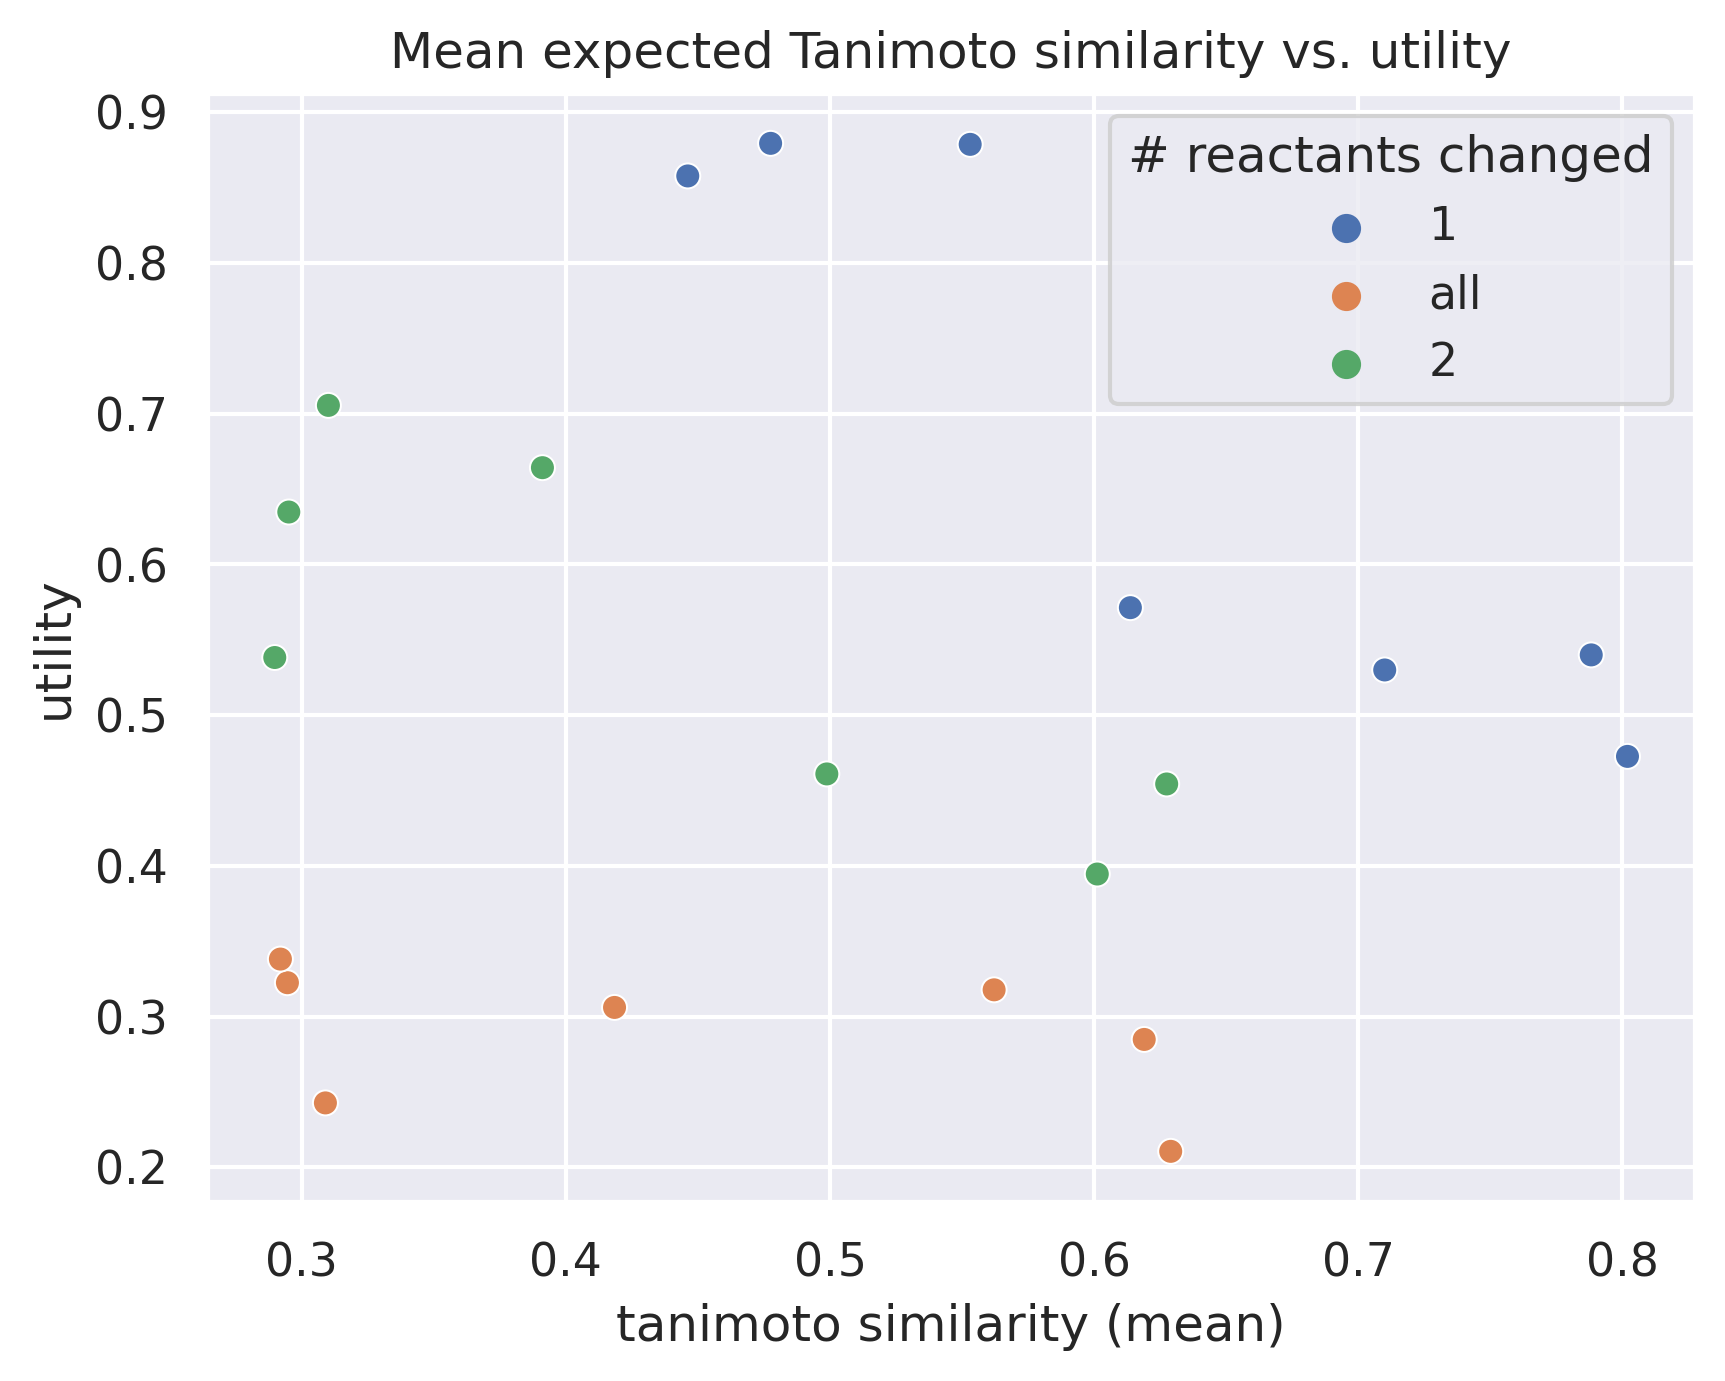

In [458]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(dpi=300)

g = sns.scatterplot(
    similarity_utility,
    x='tanimoto similarity (mean)',
    y='utility',
    hue='# reactants changed'
)

plt.title('Mean expected Tanimoto similarity vs. utility')